In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

## データセットの読み込み

In [2]:
ds_total = pd.read_csv("dataset-total.csv", index_col=0)
ds_saitama = pd.read_csv("dataset-saitama.csv", index_col=0)

## 自己回帰モデルの作成
### データの抽出

In [3]:
nrs_total = ds_total["介護に携わる人"].to_numpy()
req_total = ds_total["要介護者数"].to_numpy()
nrs_saitama = ds_saitama["介護に携わる人"].to_numpy()
req_saitama = ds_saitama["要介護者数"].to_numpy()

In [4]:
# 対2009年比に変換
# nrs_total = nrs_total / nrs_total[0]
# req_total = req_total / req_total[0]
# nrs_saitama = nrs_saitama / nrs_saitama[0]
# req_saitama = req_saitama / req_saitama[0]

## 自己回帰分析

In [5]:
def calc_arima(input_array, steps=10, draw=True, title=None):
    p, d, q = 1, 1, 1
    model = ARIMA(input_array, order=(p, d, q))
    results = model.fit()

    # 予測
    forecast = results.forecast(steps=steps)

    # 訓練データへの当てはめと予測値を結合
    pred = np.concatenate([results.predict(1, 11), forecast])

    # pandas DataFrameに変換
    df_act = pd.DataFrame(input_array, index=[2009+i for i in range(len(input_array))])
    df_prd = pd.DataFrame(pred, index=[2009+i for i in range(len(pred))])
    df = pd.concat([df_act, df_prd], axis=1)
    df.columns = ["Actual", "ARIMA"]
    
    # 描画
    if draw:
        x = df.index
        plt.plot(x, df["Actual"], label="Actual")
        plt.plot(x, df["ARIMA"], linestyle="--", color="C1", label="Predict")
        
        plt.xticks([2009+i for i in range(0, len(x), 3)])
        
        if title != None:
            plt.title(title)
        
        plt.legend()
        plt.show()

    return df    

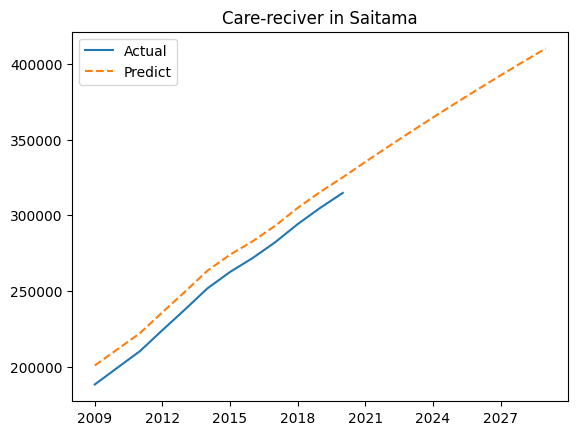

In [6]:
df_nrs_ttl = calc_arima(nrs_total, draw=False)
df_nrs_stm = calc_arima(nrs_saitama, draw=False)
df_req_ttl = calc_arima(req_total, draw=False)
df_req_stm = calc_arima(req_saitama, draw=True, title="Care-reciver in Saitama")

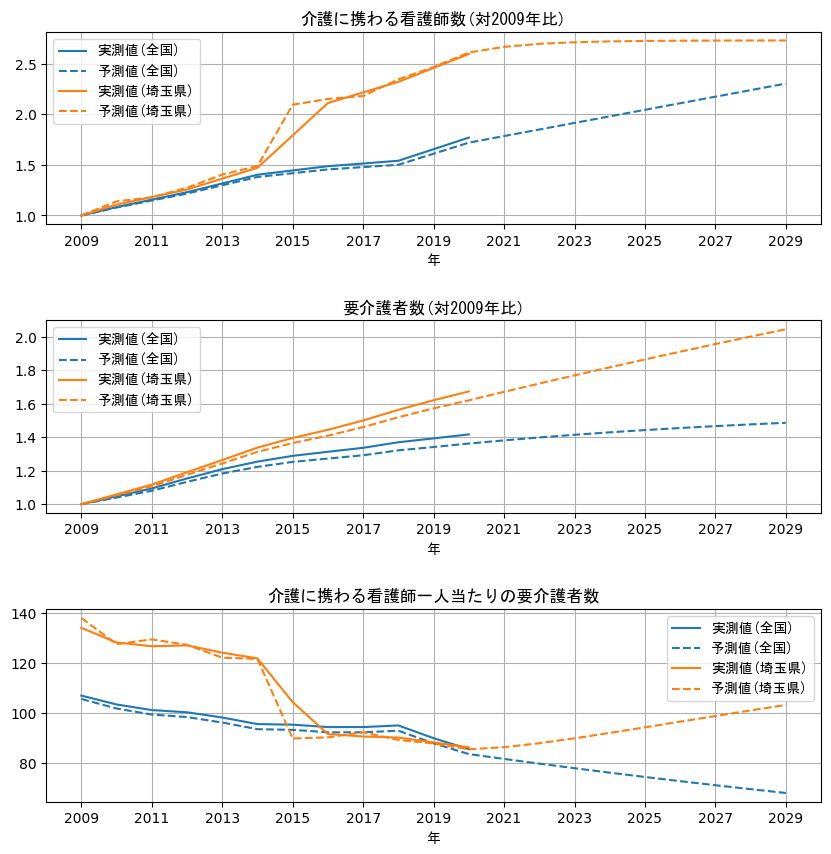

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = [fig.add_subplot(3, 1, i+1) for i in range(3)]
fig.subplots_adjust(hspace=0.5)

x = df_nrs_ttl.index

# 看護師数をプロット
y_total_act = df_nrs_ttl["Actual"] / df_nrs_ttl.loc[2009, "Actual"]
y_total_prd = df_nrs_ttl["ARIMA"] / df_nrs_ttl.loc[2009, "ARIMA"]
y_saitama_act = df_nrs_stm["Actual"] / df_nrs_stm.loc[2009, "Actual"]
y_saitama_prd = df_nrs_stm["ARIMA"] / df_nrs_stm.loc[2009, "ARIMA"]

ax[0].plot(x, y_total_act, label="実測値(全国)", color="C0")
ax[0].plot(x, y_total_prd, label="予測値(全国)", color="C0", linestyle="--")
ax[0].plot(x, y_saitama_act, label="実測値(埼玉県)", color="C1")
ax[0].plot(x, y_saitama_prd, label="予測値(埼玉県)", color="C1", linestyle="--")
ax[0].set_title("介護に携わる看護師数(対2009年比)", family="MS Gothic")

# 要介護者数をプロット
y_total_act = df_req_ttl["Actual"] / df_req_ttl.loc[2009, "Actual"]
y_total_prd = df_req_ttl["ARIMA"] / df_req_ttl.loc[2009, "ARIMA"]
y_saitama_act = df_req_stm["Actual"] / df_req_stm.loc[2009, "Actual"]
y_saitama_prd = df_req_stm["ARIMA"] / df_req_stm.loc[2009, "ARIMA"]

ax[1].plot(x, y_total_act, label="実測値(全国)", color="C0")
ax[1].plot(x, y_total_prd, label="予測値(全国)", color="C0", linestyle="--")
ax[1].plot(x, y_saitama_act, label="実測値(埼玉県)", color="C1")
ax[1].plot(x, y_saitama_prd, label="予測値(埼玉県)", color="C1", linestyle="--")
ax[1].set_title("要介護者数(対2009年比)", family="MS Gothic")


# 看護師一人当たりの負担をプロット
y_total_act = df_req_ttl["Actual"] / df_nrs_ttl["Actual"]
y_total_prd = df_req_ttl["ARIMA"] / df_nrs_ttl["ARIMA"]
y_saitama_act = df_req_stm["Actual"] / df_nrs_stm["Actual"]
y_saitama_prd = df_req_stm["ARIMA"] / df_nrs_stm["ARIMA"]

ax[2].plot(x, y_total_act, label="実測値(全国)", color="C0")
ax[2].plot(x, y_total_prd, label="予測値(全国)", color="C0", linestyle="--")
ax[2].plot(x, y_saitama_act, label="実測値(埼玉県)", color="C1")
ax[2].plot(x, y_saitama_prd, label="予測値(埼玉県)", color="C1", linestyle="--")
ax[2].set_title("介護に携わる看護師一人当たりの要介護者数", family="MS Gothic")


for i in ax:
    i.set_xticks([2009+i for i in range(0, len(x), 2)])
    i.set_xlabel("年", family="MS Gothic")
    i.legend(prop={"family": "MS Gothic"})
    i.grid()

plt.savefig("img/pred.png", format="png")
plt.show()
